In [1]:
import pandas as pd
import numpy as np
import altair as alt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans


In [ ]:
import cohere
co = cohere.ClientV2("api_key")

In [3]:
# Load the dataset to a dataframe
df_orig = pd.read_csv('https://raw.githubusercontent.com/cohere-ai/notebooks/main/notebooks/data/atis_intents_train.csv', names=['intent','query'])

# Take a small sample for illustration purposes
sample_classes = ['atis_airfare', 'atis_airline', 'atis_ground_service']
df = df_orig.sample(frac=0.1, random_state=30)
df = df[df.intent.isin(sample_classes)]
df_orig = df_orig.drop(df.index)
df.reset_index(drop=True,inplace=True)

# Remove unnecessary column 
intents = df['intent'] #save for a later need
df.drop(columns=['intent'], inplace=True)

In [4]:
df

,query
0,which airlines fly from boston to washington ...
1,show me the airlines that fly between toronto...
2,show me round trip first class tickets from n...
3,i'd like the lowest fare from denver to pitts...
4,show me a list of ground transportation at bo...
...,...
86,what ground transportation is there in atlanta
87,can i take a single airline from la to charlo...
88,what is the cost for a one way trip from pitt...
89,what ground transportation is available in ba...


In [5]:
#  create embeddings for the search repository
def get_embeddings(texts, model="embed-english-v3.0", input_type="search_document"):
    output = co.embed(
        texts=texts, 
        model=model, 
        input_type=input_type, 
        embedding_types=["float"]
    )
    return output.embeddings.float

df['query_embeds'] = get_embeddings(df['query'].tolist())

In [6]:
df

,query,query_embeds
0,which airlines fly from boston to washington ...,"[0.02609253, 0.012168884, -0.008903503, 0.0114..."
1,show me the airlines that fly between toronto...,"[0.013801575, 0.017181396, -0.014984131, -0.00..."
2,show me round trip first class tickets from n...,"[0.02053833, -0.038482666, 0.061523438, 0.0099..."
3,i'd like the lowest fare from denver to pitts...,"[0.0016708374, 0.015625, -0.029022217, 0.03759..."
4,show me a list of ground transportation at bo...,"[0.037628174, -0.007888794, -0.0024662018, -0...."
...,...,...
86,what ground transportation is there in atlanta,"[0.014678955, 0.022964478, -0.020690918, -0.00..."
87,can i take a single airline from la to charlo...,"[-0.004180908, -0.031555176, -0.008918762, 0.0..."
88,what is the cost for a one way trip from pitt...,"[0.028198242, -0.015113831, 0.008026123, 0.009..."
89,what ground transportation is available in ba...,"[0.019744873, 0.012123108, -0.03164673, -0.027..."


In [7]:
# Visualizing via dimensionality reduction

# Function to return the principal components
def get_pc(arr, n):
    pca = PCA(n_components=n)
    embeds_transform = pca.fit_transform(arr)
    return embeds_transform
  
# Reduce embeddings to 10 principal components to aid visualization
embeds = np.array(df['query_embeds'].tolist())
embeds_pc = get_pc(embeds, 10)

In [9]:
embeds_pc[:]

(91, 10)

<Axes: >

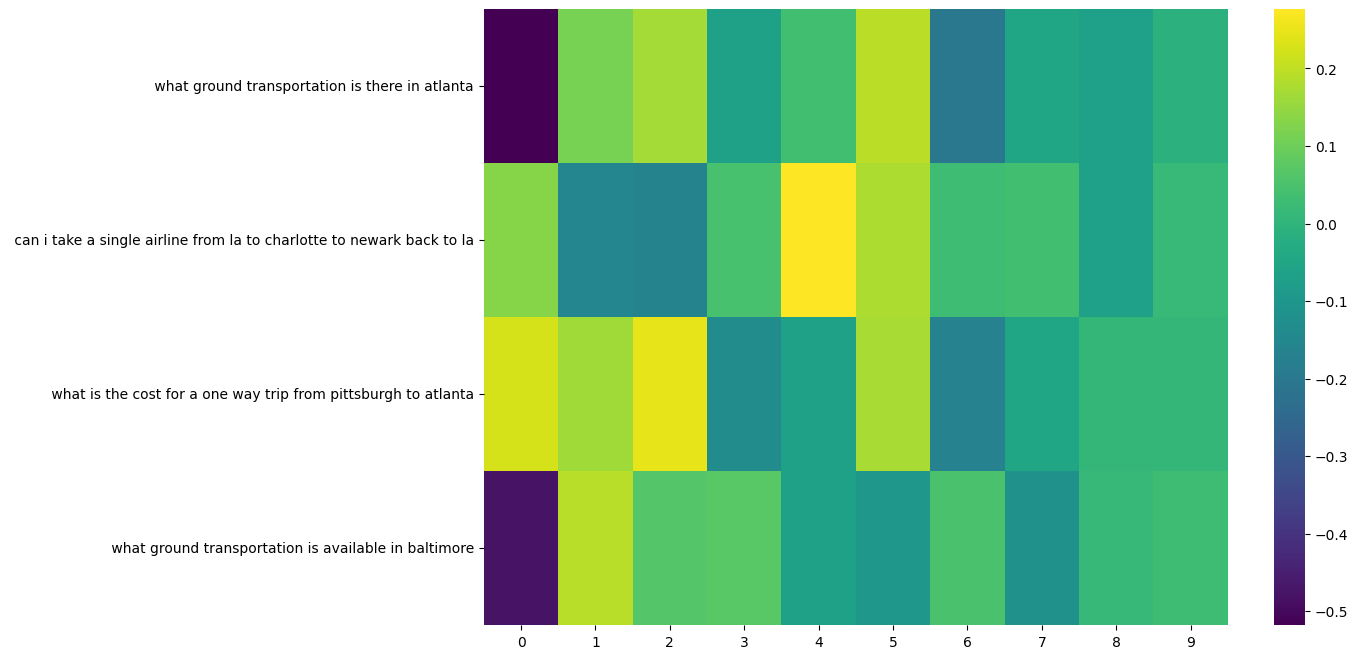

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = df['query'].to_list()[-5:-1]

# Plotting the heatmap
plt.figure(figsize=(12, 8))  # Adjust figure size as needed
sns.heatmap(embeds_pc[-5:-1], cmap="viridis", annot=False, cbar=True, yticklabels=labels)

#### Creating a semantic search system


In [14]:
# Define new query
new_query = "How can I find a taxi or a bus when the plane lands?"

# Get embeddings of the new query
new_query_embeds = get_embeddings([new_query], input_type="search_query")[0]

In [15]:
# Calculate cosine similarity between the search query and existing queries
def get_similarity(target, candidates):
    # Turn list into array
    candidates = np.array(candidates)
    target = np.expand_dims(np.array(target),axis=0)

    # Calculate cosine similarity
    sim = cosine_similarity(target, candidates)
    sim = np.squeeze(sim).tolist()
    sort_index = np.argsort(sim)[::-1]
    sort_score = [sim[i] for i in sort_index]
    similarity_scores = zip(sort_index,sort_score)

    # Return similarity scores
    return similarity_scores

# Get the similarity between the search query and existing queries
similarity = get_similarity(new_query_embeds, embeds[:5])


In [16]:
# View the top 5 articles
print('Query:')
print(new_query,'\n')

print('Most Similar Documents:')
for idx, sim in similarity:
    print(f'Similarity: {sim:.2f};', df.iloc[idx]['query'])

Query:
How can I find a taxi or a bus when the plane lands? 

Most Similar Documents:
Similarity: 0.37;  show me a list of ground transportation at boston airport
Similarity: 0.27;  show me the airlines that fly between toronto and denver
Similarity: 0.25;  which airlines fly from boston to washington dc via other cities
Similarity: 0.18;  i'd like the lowest fare from denver to pittsburgh
Similarity: 0.17;  show me round trip first class tickets from new york to miami


#### Text Clustering

In [17]:
# Embed the text for clustering
df['clustering_embeds'] = get_embeddings(df['query'].tolist(), input_type="clustering")
embeds = np.array(df['clustering_embeds'].tolist())

In [18]:
df

,query,query_embeds,clustering_embeds
0,which airlines fly from boston to washington ...,"[0.02609253, 0.012168884, -0.008903503, 0.0114...","[0.02746582, 0.014625549, 0.010131836, -0.0153..."
1,show me the airlines that fly between toronto...,"[0.013801575, 0.017181396, -0.014984131, -0.00...","[-0.024978638, 0.02748108, -0.023117065, -0.02..."
2,show me round trip first class tickets from n...,"[0.02053833, -0.038482666, 0.061523438, 0.0099...","[0.020187378, -0.01953125, 0.08099365, -0.0265..."
3,i'd like the lowest fare from denver to pitts...,"[0.0016708374, 0.015625, -0.029022217, 0.03759...","[-0.0036182404, 0.034820557, -0.029449463, 0.0..."
4,show me a list of ground transportation at bo...,"[0.037628174, -0.007888794, -0.0024662018, -0....","[0.01676941, -0.00086069107, -0.013656616, -0...."
...,...,...,...
86,what ground transportation is there in atlanta,"[0.014678955, 0.022964478, -0.020690918, -0.00...","[0.008415222, 0.012748718, -0.017608643, -0.01..."
87,can i take a single airline from la to charlo...,"[-0.004180908, -0.031555176, -0.008918762, 0.0...","[-0.020111084, -0.029205322, 0.025619507, -0.0..."
88,what is the cost for a one way trip from pitt...,"[0.028198242, -0.015113831, 0.008026123, 0.009...","[0.03286743, -0.0029621124, 0.025726318, -0.02..."
89,what ground transportation is available in ba...,"[0.019744873, 0.012123108, -0.03164673, -0.027...","[0.0055160522, 0.012161255, -0.027542114, -0.0..."


In [19]:
# perform k means clustering

# Pick the number of clusters
n_clusters = 2

# Cluster the embeddings
kmeans_model = KMeans(n_clusters=n_clusters, random_state=0)
classes = kmeans_model.fit_predict(embeds).tolist()

# Store the cluster assignments
df_clust = df.copy()
df_clust['cluster'] = (list(map(str,classes)))

In [20]:
df_clust

,query,query_embeds,clustering_embeds,cluster
0,which airlines fly from boston to washington ...,"[0.02609253, 0.012168884, -0.008903503, 0.0114...","[0.02746582, 0.014625549, 0.010131836, -0.0153...",0
1,show me the airlines that fly between toronto...,"[0.013801575, 0.017181396, -0.014984131, -0.00...","[-0.024978638, 0.02748108, -0.023117065, -0.02...",0
2,show me round trip first class tickets from n...,"[0.02053833, -0.038482666, 0.061523438, 0.0099...","[0.020187378, -0.01953125, 0.08099365, -0.0265...",0
3,i'd like the lowest fare from denver to pitts...,"[0.0016708374, 0.015625, -0.029022217, 0.03759...","[-0.0036182404, 0.034820557, -0.029449463, 0.0...",0
4,show me a list of ground transportation at bo...,"[0.037628174, -0.007888794, -0.0024662018, -0....","[0.01676941, -0.00086069107, -0.013656616, -0....",1
...,...,...,...,...
86,what ground transportation is there in atlanta,"[0.014678955, 0.022964478, -0.020690918, -0.00...","[0.008415222, 0.012748718, -0.017608643, -0.01...",1
87,can i take a single airline from la to charlo...,"[-0.004180908, -0.031555176, -0.008918762, 0.0...","[-0.020111084, -0.029205322, 0.025619507, -0.0...",0
88,what is the cost for a one way trip from pitt...,"[0.028198242, -0.015113831, 0.008026123, 0.009...","[0.03286743, -0.0029621124, 0.025726318, -0.02...",0
89,what ground transportation is available in ba...,"[0.019744873, 0.012123108, -0.03164673, -0.027...","[0.0055160522, 0.012161255, -0.027542114, -0.0...",1


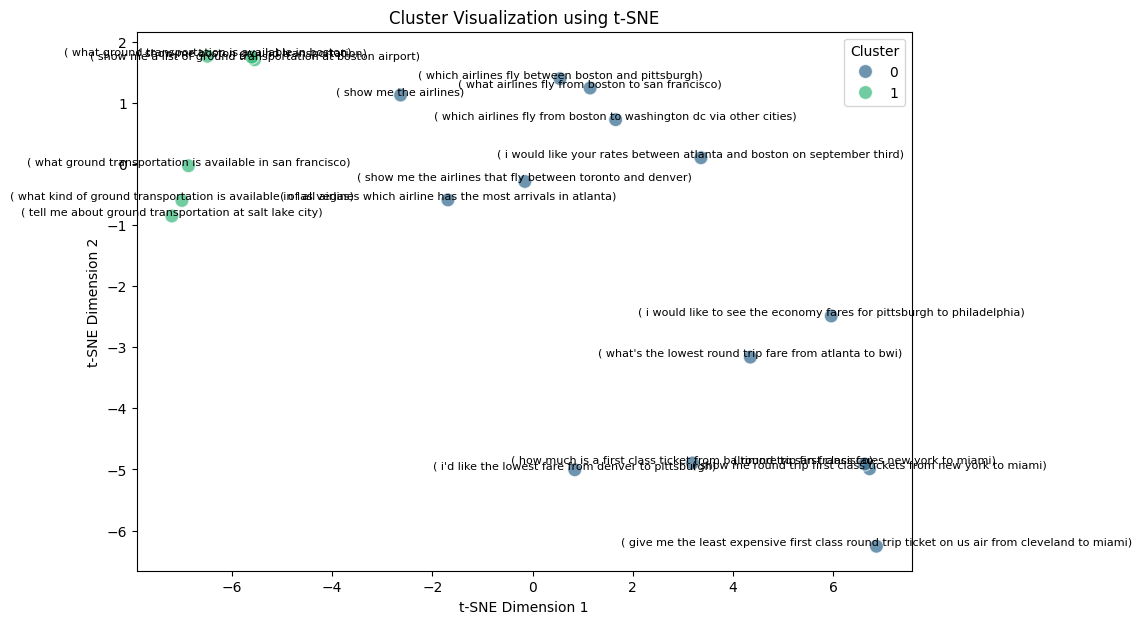

In [24]:
# Using t-SNE (t-distributed Stochastic Neighbor Embedding), to project the high-dimensional clustering_embeds vectors into 2D.
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeds_pc)
clusters = df_clust['cluster'].values

df_tsne = pd.DataFrame(tsne_results, columns=['x', 'y'])
df_tsne['query'] = df['query']
df_tsne['cluster'] = clusters

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='x', y='y', hue='cluster', palette='viridis', data=df_tsne.head(20), s=100, alpha=0.7,
)

for i in range(len(df_tsne.head(20))):
    plt.text(
        df_tsne['x'][i], df_tsne['y'][i] + 0.01,  # Adjust the position slightly above the point
        f"({df_tsne['query'][i]})",  
        fontsize=8, color='black', ha='center'
    )
plt.title("Cluster Visualization using t-SNE")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster")
plt.show()